In [1]:
import numpy as np
import pandas as pd
import hvplot.pandas
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

from numpy.random import seed
seed(1)

from tensorflow import random
random.set_seed(2)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [3]:
# Load the stock prices, remove timestamp from the index so we can call up the information down the line.

SP500_full = pd.read_csv('Resources/sp500_mom_short.csv', index_col='date',infer_datetime_format=True, parse_dates=True)
SP500_full.reset_index(inplace=True)
SP500_full['date']=SP500_full['date'].dt.date
SP500_full.index = pd.to_datetime(SP500_full['date'])
SP500_full.drop(columns=['date'],inplace=True)

# SP500_full.tail()

In [4]:
# Trim the dataframe to the relevant weeks
df=SP500_full.loc[:'2020-03-01']

In [5]:
# This function accepts the column number for the features (X) and the target (y):
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [7]:
# Creating the features (X) and target (y) data using the window_data() function.
# Use a window of 2
window_size = 2

# Column index 1 is the `Close` column
feature_column = 5
target_column = 5
X, y = window_data(df, window_size, feature_column, target_column)

In [8]:
# Use 70% of the data for training and the remaineder for testing

split = int(0.7 *len(X))
X_train_rnn = X[: split -1]
X_test = X[split:]
y_train_rnn = y[: split -1]
y_test = y[split:]

X_train_rnn, X_val_rnn, y_train_rnn, y_val_rnn = train_test_split(X_train_rnn, y_train_rnn)

In [9]:
# Use MinMaxScaler to scale the data between 0 and 1. 

scaler = MinMaxScaler()
scaler.fit(X)
X_train_rnn =scaler.transform(X_train_rnn)
X_val_rnn =scaler.transform(X_val_rnn)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train_rnn = scaler.transform(y_train_rnn)
y_val_rnn = scaler.transform(y_val_rnn)
y_test =scaler.transform(y_test)

In [10]:
# Reshape the features for the model
X_train_rnn = X_train_rnn.reshape((X_train_rnn.shape[0], X_train_rnn.shape[1], 1))
X_val_rnn = X_val_rnn.reshape((X_val_rnn.shape[0], X_val_rnn.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

---

## Build and Train the LSTM RNN

In [25]:
# Build the LSTM model. 
model = Sequential()

number_units = 50
dropout_fraction = 0.7

#first layer:
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train_rnn.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
#second layer
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
#third layer
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
#fourth layer
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

#output layer
model.add(Dense(1))

In [26]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [27]:
# Summarize the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 2, 50)             10400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 2, 50)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 2, 50)             20200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 2, 50)             0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 2, 50)             20200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 2, 50)             0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 50)               

In [28]:
# Train the model
# Use at least 10 epochs
# Do not shuffle the data
# Experiement with the batch size, but a smaller batch size is recommended
batch_size = 60
epochs = 250
history = model.fit(
    X_train_rnn,
    y_train_rnn,
    validation_data=(X_val_rnn, y_val_rnn),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

Train on 646 samples, validate on 216 samples
Epoch 1/250
646/646 [==============================] - 5s 8ms/sample - loss: 0.2595 - val_loss: 0.2307
Epoch 2/250
646/646 [==============================] - 0s 164us/sample - loss: 0.1808 - val_loss: 0.1321
Epoch 3/250
646/646 [==============================] - 0s 159us/sample - loss: 0.0865 - val_loss: 0.0321
Epoch 4/250
646/646 [==============================] - 0s 151us/sample - loss: 0.0571 - val_loss: 0.0299
Epoch 5/250
646/646 [==============================] - 0s 150us/sample - loss: 0.0528 - val_loss: 0.0393
Epoch 6/250
646/646 [==============================] - 0s 147us/sample - loss: 0.0497 - val_loss: 0.0315
Epoch 7/250
646/646 [==============================] - 0s 135us/sample - loss: 0.0423 - val_loss: 0.0250
Epoch 8/250
646/646 [==============================] - 0s 139us/sample - loss: 0.0426 - val_loss: 0.0252
Epoch 9/250
646/646 [==============================] - 0s 127us/sample - loss: 0.0383 - val_loss: 0.0183
Epoch 10/25

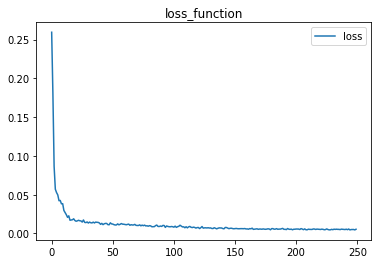

In [29]:
plt.plot(history.history['loss'])
plt.title('loss_function')
plt.legend(['loss'])
plt.show()

---

## Model Performance

In this section, you will evaluate the model using the test data. 

You will need to:
1. Evaluate the model using the `X_test` and `y_test` data.
2. Use the X_test data to make predictions
3. Create a DataFrame of Real (y_test) vs predicted values. 
4. Plot the Real vs predicted values as a line chart

### Hints
Remember to apply the `inverse_transform` function to the predicted and y_test values to recover the actual closing prices.

In [15]:
# Evaluate the model
# YOUR CODE HERE!
model.evaluate(X_test, y_test)

370/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.0008535964338964707

In [16]:
X_train_rnn.shape

(646, 2, 1)

In [17]:
seq = df[df.columns[feature_column]][-2:].tolist()
forecast=[]
for i in range (5):
    prediction = model.predict([np.array(seq).reshape(1,X_train_rnn.shape[1],1)])
    seq.append(prediction[0][0])
    seq.pop(0)
    forecast.append([prediction[0][0]])

In [18]:
forecast_scaled=scaler.inverse_transform(forecast)

In [19]:
fwd_prices=forecast_scaled.ravel()

In [20]:
# Make some predictions
# YOUR CODE HERE!
predicted = model.predict(X_test)

In [21]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [22]:
# Create a DataFrame of Real and Predicted values
stock_closing = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
})
stock_closing.head()

Real   Predicted
0  959.714599  942.289551
1  960.975965  942.041870
2  972.903084  949.112854
3  963.946068  953.215149
4  982.537176  958.341125

In [23]:


fig = plt.figure()
stock_closing.plot()
fig.savefig('Resources/plot.png')

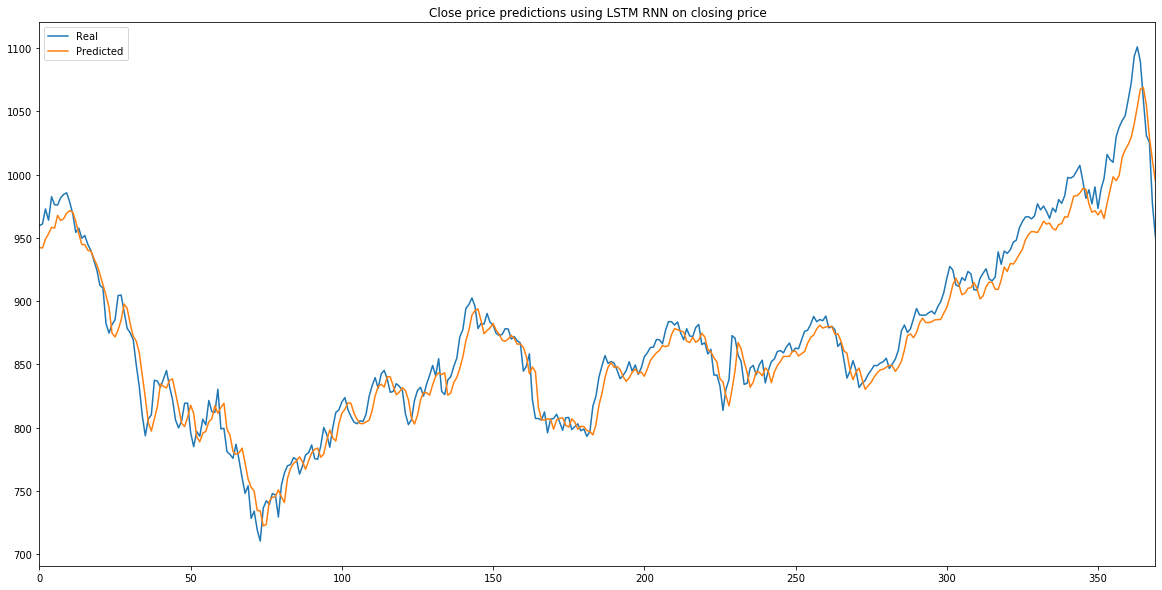

In [24]:
# Plot the real vs predicted values as a line chart
# YOUR CODE HERE!
STOCK_CLOSE=stock_closing.plot(title='Close price predictions using LSTM RNN on closing price',figsize=(20,10))

In [25]:
real_prices=SP500_full[SP500_full.columns[feature_column]]['2020-03-02':'2020-03-07'].tolist()

In [26]:
A=SP500_full.loc['2020-03-02':'2020-03-07'].index

In [27]:
out_of_sample=pd.DataFrame({'Real_Prices':real_prices,
                          'Look_Fwd_Prices':fwd_prices},
                          index=A)
#                            index=['2020-03-02','2020-03-03','2020-03-04','2020-03-05','2020-03-06'])

In [28]:
out_of_sample

Real_Prices  Look_Fwd_Prices
date                                    
2020-03-02  1000.000000       980.735300
2020-03-03   995.393589       990.533827
2020-03-04  1038.476181       970.590293
2020-03-05  1012.783297       971.333211
2020-03-06  1008.364852       958.902050

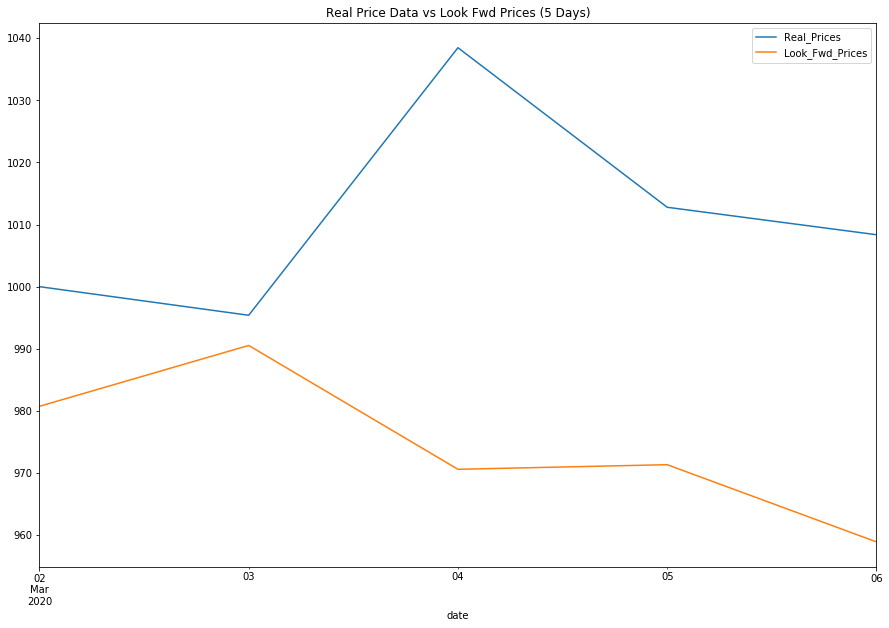

In [29]:
OUT_SAMP=out_of_sample.plot(figsize=(15,10), title='Real Price Data vs Look Fwd Prices (5 Days)')

In [30]:
look_fwd=pd.concat([SP500_full[SP500_full.columns[feature_column]][:'2020-03-07'],out_of_sample],axis=1,join='outer')
# df[df.columns[feature_column]]

In [31]:
# SP500_full[SP500_full.columns[feature_column]][:'2020-03-06']

In [32]:
# look_fwd['CHECK']=SP500_full[SP500_full.columns[feature_column]][:'2020-03-06']

In [33]:
look_fwd_2020=look_fwd.iloc[-90:]

In [34]:
# look_fwd_2020.drop(columns='CHECK',inplace=True)

In [35]:
look_fwd_2020.drop(columns=['Real_Prices'], inplace=True)
look_fwd_2020

C:\Users\mrich\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


portfolio_value  Look_Fwd_Prices
date                                        
2019-10-28       876.527181              NaN
2019-10-29       881.093964              NaN
2019-10-30       875.235610              NaN
2019-10-31       878.069564              NaN
2019-11-01       886.155990              NaN
...                     ...              ...
2020-03-02      1000.000000       980.735300
2020-03-03       995.393589       990.533827
2020-03-04      1038.476181       970.590293
2020-03-05      1012.783297       971.333211
2020-03-06      1008.364852       958.902050

[90 rows x 2 columns]

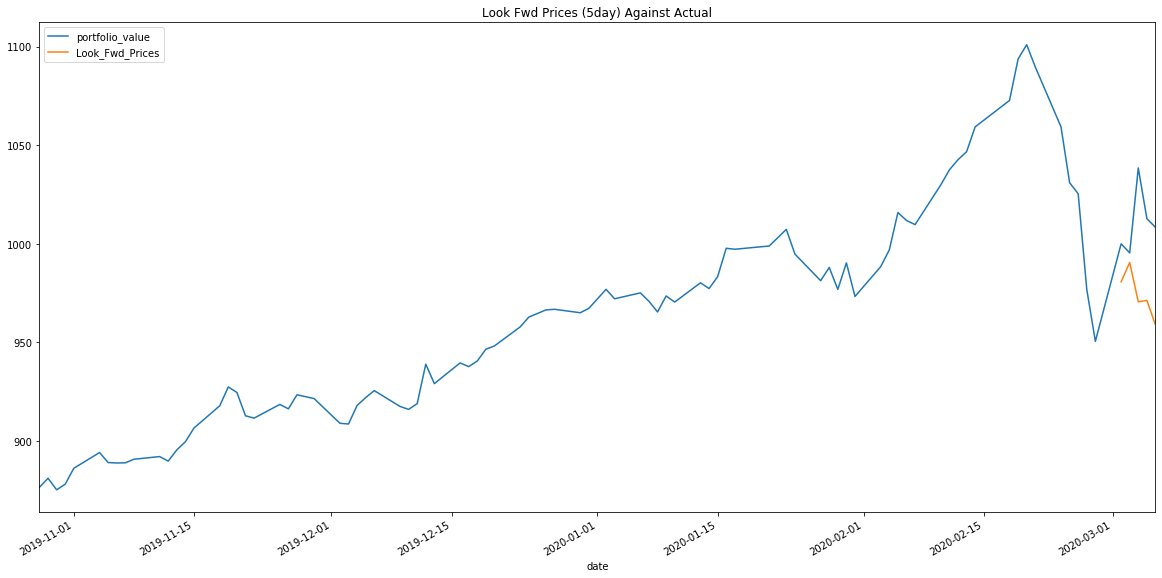

In [36]:
LOOK_FWD_2020=look_fwd_2020.plot(figsize=(20,10),title='Look Fwd Prices (5day) Against Actual')

---

---

---

# WEEK 2 PREDICTIONS

In [39]:
# Load the stock prices
week2_stocks = pd.read_csv('Resources/sp500_mom_short_wk2.csv', index_col='date',infer_datetime_format=True, parse_dates=True)
week2_stocks.reset_index(inplace=True)
week2_stocks['date']=week2_stocks['date'].dt.date
# SP500_full.set_index(['date'],inplace=True)
week2_stocks.index = pd.to_datetime(week2_stocks['date'])
week2_stocks.drop(columns=['date'],inplace=True)

week2_stocks.tail()

CLX      DG    NEM    REGN    ROL  portfolio_value  \
date                                                                
2020-03-30  174.48  146.77  46.36  473.00  35.84       971.615201   
2020-03-31  173.25  151.01  45.28  488.29  36.14       978.999923   
2020-04-01  174.66  153.16  46.47  496.65  35.16       987.001938   
2020-04-02  179.70  159.70  48.23  498.75  35.68      1012.136978   
2020-04-03  177.54  162.20  47.15  493.32  36.05      1007.701260   

            port_val_chg_1_days  port_val_chg_5_days  port_val_chg_5_days_bin  
date                                                                           
2020-03-30             0.021598             0.069426                        1  
2020-03-31             0.007600             0.038575                        1  
2020-04-01             0.008174             0.073732                        1  
2020-04-02             0.025466             0.064861                        1  
2020-04-03            -0.004383             0.059540                        1

In [40]:
#I am trimming the dataframe
#to the end of wk1 March. 
df2=week2_stocks.loc[:'2020-03-06']

In [41]:
# This function accepts the column number for the features (X) and the target (y):
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [42]:
# Predict Closing Prices using a 10 day window of previous closing prices
# Try a window size anywhere from 1 to 10 and see how the model performance changes
#jjp - need to add a for loop 

# Creating the features (X) and target (y) data using the window_data() function.
window_size2 = 2

# Column index 1 is the `Close` column
feature_column2 = 5
target_column2 = 5
X, y = window_data(df2, window_size2, feature_column2, target_column2)

In [43]:
# Use 70% of the data for training and the remaineder for testing
# YOUR CODE HERE!
from sklearn.model_selection import train_test_split

split = int(0.7 *len(X))
X_train_rnn = X[: split -1]
X_test = X[split:]
y_train_rnn = y[: split -1]
y_test = y[split:]

X_train_rnn, X_val_rnn, y_train_rnn, y_val_rnn = train_test_split(X_train_rnn, y_train_rnn)

In [44]:
# Use MinMaxScaler to scale the data between 0 and 1. 
# YOUR CODE HERE!
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X)
X_train_rnn =scaler.transform(X_train_rnn)
X_val_rnn =scaler.transform(X_val_rnn)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train_rnn = scaler.transform(y_train_rnn)
y_val_rnn = scaler.transform(y_val_rnn)
y_test =scaler.transform(y_test)

In [45]:
# Reshape the features for the model
# YOUR CODE HERE!
X_train_rnn = X_train_rnn.reshape((X_train_rnn.shape[0], X_train_rnn.shape[1], 1))
X_val_rnn = X_val_rnn.reshape((X_val_rnn.shape[0], X_val_rnn.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print (f"X_train sample values:\n{X_train_rnn[:5]} \n")
print (f"X_val_rnn sample values:\n{X_val_rnn[:5]} \n")
print (f"X_test sample values:\n{X_test[:5]}")

X_train sample values:
[[[0.26021351]
  [0.22057373]]

 [[0.12843365]
  [0.11177363]]

 [[0.18252821]
  [0.18170113]]

 [[0.16508473]
  [0.16306651]]

 [[0.49907314]
  [0.47962186]]] 

X_val_rnn sample values:
[[[0.52934847]
  [0.54272713]]

 [[0.15708679]
  [0.16754985]]

 [[0.27964155]
  [0.28539769]]

 [[0.21493867]
  [0.23750442]]

 [[0.47252458]
  [0.46166538]]] 

X_test sample values:
[[[0.74636727]
  [0.74664605]]

 [[0.75754539]
  [0.75664202]]

 [[0.76768728]
  [0.74766582]]

 [[0.75858004]
  [0.7392105 ]]

 [[0.75000129]
  [0.75940024]]]


---

## Build and Train the LSTM RNN

In this section, you will design a custom LSTM RNN and fit (train) it using the training data.

You will need to:
1. Define the model architecture
2. Compile the model
3. Fit the model to the training data

### Hints:
You will want to use the same model architecture and random seed for both notebooks. This is necessary to accurately compare the performance of the FNG model vs the closing price model. 

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [47]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# YOUR CODE HERE!
model2 = Sequential()

number_units = 100
dropout_fraction = 0.7

#first layer:
model2.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train_rnn.shape[1], 1))
    )
model2.add(Dropout(dropout_fraction))
#second layer
model2.add(LSTM(units=number_units, return_sequences=True))
model2.add(Dropout(dropout_fraction))
#third layer
model2.add(LSTM(units=number_units, return_sequences=True))
model2.add(Dropout(dropout_fraction))
# #fourth layer
model2.add(LSTM(units=number_units))
model2.add(Dropout(dropout_fraction))

#output layer
model2.add(Dense(1))

In [48]:
# Compile the model
# YOUR CODE HERE!
model2.compile(optimizer="adam", loss="mean_squared_error")

In [49]:
# Summarize the model
# YOUR CODE HERE!
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 2, 100)            40800     
_________________________________________________________________
dropout_4 (Dropout)          (None, 2, 100)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 2, 100)            80400     
_________________________________________________________________
dropout_5 (Dropout)          (None, 2, 100)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 2, 100)            80400     
_________________________________________________________________
dropout_6 (Dropout)          (None, 2, 100)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 100)              

In [50]:
# Train the model
# Use at least 10 epochs
# Do not shuffle the data
# Experiement with the batch size, but a smaller batch size is recommended
# YOUR CODE HERE!
batch_size = 60
epochs = 250
model2.fit(
    X_train_rnn,
    y_train_rnn,
    validation_data=(X_val_rnn, y_val_rnn),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

Train on 648 samples, validate on 217 samples
Epoch 1/250
648/648 [==============================] - 6s 9ms/sample - loss: 0.1084 - val_loss: 0.0770
Epoch 2/250
648/648 [==============================] - 0s 192us/sample - loss: 0.0443 - val_loss: 0.0300
Epoch 3/250
648/648 [==============================] - 0s 168us/sample - loss: 0.0317 - val_loss: 0.0264
Epoch 4/250
648/648 [==============================] - 0s 168us/sample - loss: 0.0257 - val_loss: 0.0194
Epoch 5/250
648/648 [==============================] - 0s 165us/sample - loss: 0.0208 - val_loss: 0.0097
Epoch 6/250
648/648 [==============================] - 0s 175us/sample - loss: 0.0102 - val_loss: 0.0015
Epoch 7/250
648/648 [==============================] - 0s 159us/sample - loss: 0.0080 - val_loss: 0.0023
Epoch 8/250
648/648 [==============================] - 0s 160us/sample - loss: 0.0083 - val_loss: 6.9351e-04
Epoch 9/250
648/648 [==============================] - 0s 159us/sample - loss: 0.0068 - val_loss: 0.0011
Epoch 1

---

## Model Performance

In this section, you will evaluate the model using the test data. 

You will need to:
1. Evaluate the model using the `X_test` and `y_test` data.
2. Use the X_test data to make predictions
3. Create a DataFrame of Real (y_test) vs predicted values. 
4. Plot the Real vs predicted values as a line chart

### Hints
Remember to apply the `inverse_transform` function to the predicted and y_test values to recover the actual closing prices.

In [51]:
# Evaluate the model
# YOUR CODE HERE!
model2.evaluate(X_test, y_test)

372/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.0052840537491745205

In [52]:
X_train_rnn.shape

(648, 2, 1)

In [53]:
seq2 = df2[df2.columns[feature_column2]][-2:].tolist()
forecast2=[]
for i in range (5):
    prediction2 = model2.predict([np.array(seq2).reshape(1,X_train_rnn.shape[1],1)])
    seq2.append(prediction2[0][0])
    seq2.pop(0)
    forecast2.append([prediction2[0][0]])

In [54]:
forecast_scaled2=scaler.inverse_transform(forecast2)

In [55]:
fwd_prices2=forecast_scaled2.ravel()

In [56]:
# Make some predictions
# YOUR CODE HERE!
predicted2 = model2.predict(X_test)

In [57]:
# Recover the original prices instead of the scaled version
predicted_prices2 = scaler.inverse_transform(predicted2)
real_prices2 = scaler.inverse_transform(y_test.reshape(-1, 1))

In [58]:
# Create a DataFrame of Real and Predicted values
stock_closing2 = pd.DataFrame({
    "Real": real_prices2.ravel(),
    "Predicted": predicted_prices2.ravel()
})
stock_closing2.head()

Real   Predicted
0  939.133812  890.227295
1  935.319644  890.831604
2  931.726810  891.486267
3  940.305833  891.061279
4  931.272134  890.373291

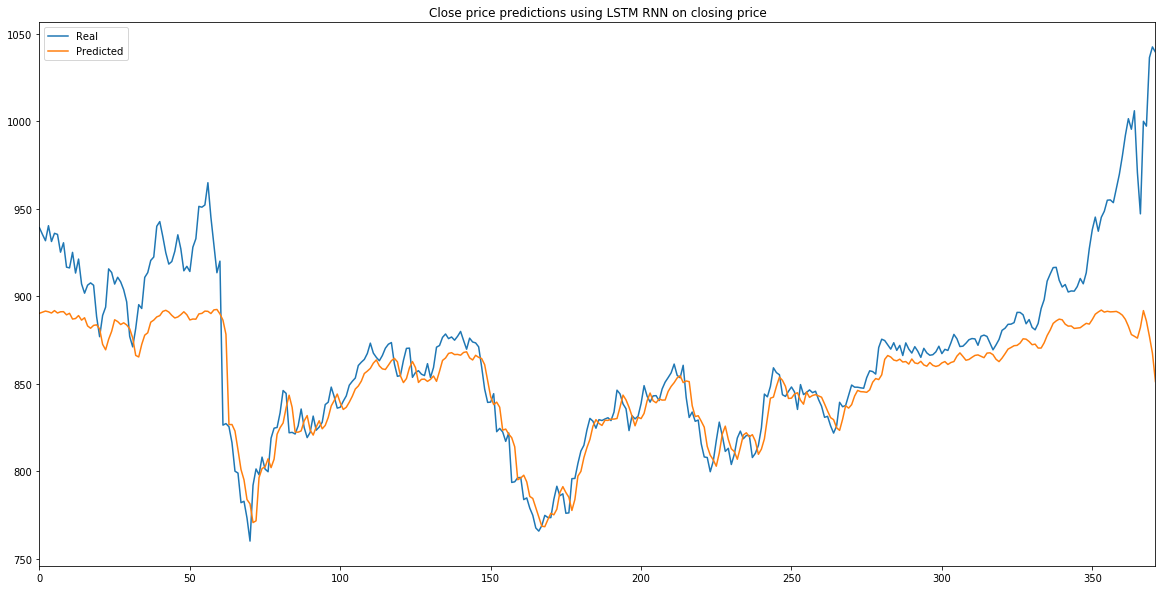

In [59]:
# Plot the real vs predicted values as a line chart
# YOUR CODE HERE!
STOCK_CLOSE2=stock_closing2.plot(title='Close price predictions using LSTM RNN on closing price',figsize=(20,10))

In [60]:
real_prices2=week2_stocks[week2_stocks.columns[feature_column]]['2020-03-09':'2020-03-13'].tolist()

In [61]:
A=week2_stocks.loc['2020-03-09':'2020-03-13'].index

In [62]:
out_of_sample2=pd.DataFrame({'Real_Prices':real_prices2,
                          'Look_Fwd_Prices':fwd_prices2},
                          index=A)
#                            index=['2020-03-02','2020-03-03','2020-03-04','2020-03-05','2020-03-06'])

In [63]:
out_of_sample2

Real_Prices  Look_Fwd_Prices
date                                    
2020-03-09  1006.942041       741.821792
2020-03-10  1029.190233       741.843434
2020-03-11   987.538412       742.273338
2020-03-12   913.844031       742.419780
2020-03-13   940.232126       742.753162

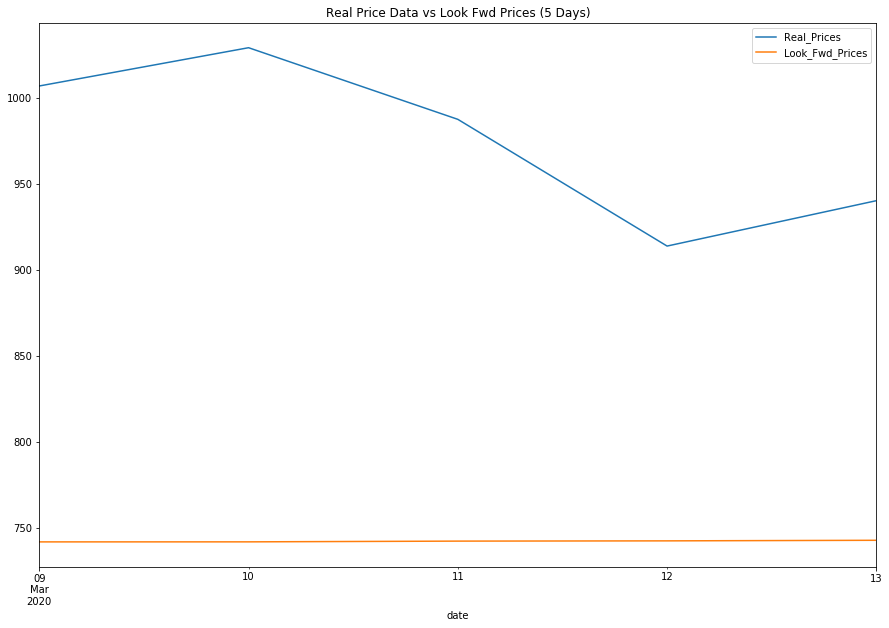

In [64]:
OUT_SAMP2=out_of_sample2.plot(figsize=(15,10), title='Real Price Data vs Look Fwd Prices (5 Days)')

In [65]:
look_fwd2=pd.concat([week2_stocks[week2_stocks.columns[feature_column2]][:'2020-03-13'],out_of_sample2],axis=1,join='outer')
# df[df.columns[feature_column]]

In [66]:
# SP500_full[SP500_full.columns[feature_column]][:'2020-03-06']

In [67]:
# look_fwd['CHECK']=SP500_full[SP500_full.columns[feature_column]][:'2020-03-06']

In [68]:
look_fwd_2020_2=look_fwd2.iloc[-90:]

In [69]:
# look_fwd_2020.drop(columns='CHECK',inplace=True)

In [70]:
look_fwd_2020_2.drop(columns=['Real_Prices'], inplace=True)
look_fwd_2020_2

C:\Users\mrich\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


portfolio_value  Look_Fwd_Prices
date                                        
2019-11-04       866.085186              NaN
2019-11-05       873.297213              NaN
2019-11-06       869.757840              NaN
2019-11-07       867.481442              NaN
2019-11-08       871.141936              NaN
...                     ...              ...
2020-03-09      1006.942041       741.821792
2020-03-10      1029.190233       741.843434
2020-03-11       987.538412       742.273338
2020-03-12       913.844031       742.419780
2020-03-13       940.232126       742.753162

[90 rows x 2 columns]

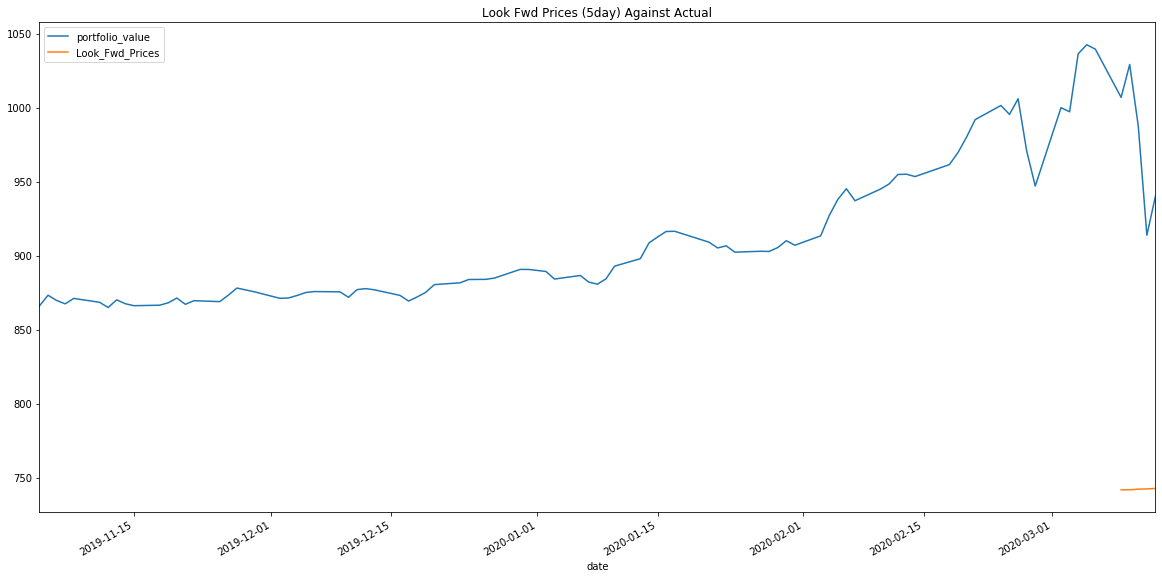

In [71]:
LOOK_FWD_2020_2=look_fwd_2020_2.plot(figsize=(20,10),title='Look Fwd Prices (5day) Against Actual')

In [72]:
# def lstm_summary1():
#     model_summary1 = model.summary()
#     return model_summary1

# def lstm_summary2():
#     model_summary2 = model2.summary()
#     return model_summary2

# def stock_plot1():
#     STOCK_CLOSE=stock_closing.plot(title='Close price predictions using LSTM RNN on closing price',figsize=(20,10))
#     return STOCK_CLOSE

# def stock_plot2():
#     STOCK_CLOSE2=stock_closing2.plot(title='Close price predictions using LSTM RNN on closing price',figsize=(20,10))
#     return STOCK_CLOSE2

# def out_samp1():
#     LOOK_FWD_2020=look_fwd_2020.plot(figsize=(20,10),title='Look Fwd Prices (5day) Against Actual')
#     return LOOK_FWD_2020

# def out_samp2():
#     LOOK_FWD_2020_2=look_fwd_2020.plot(figsize=(20,10),title='Look Fwd Prices (5day) Against Actual')
#     return LOOK_FWD_2020_2

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 2, 100)            40800     
_________________________________________________________________
dropout (Dropout)            (None, 2, 100)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 2, 100)            80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 100)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 2, 100)            80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 2, 100)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               8

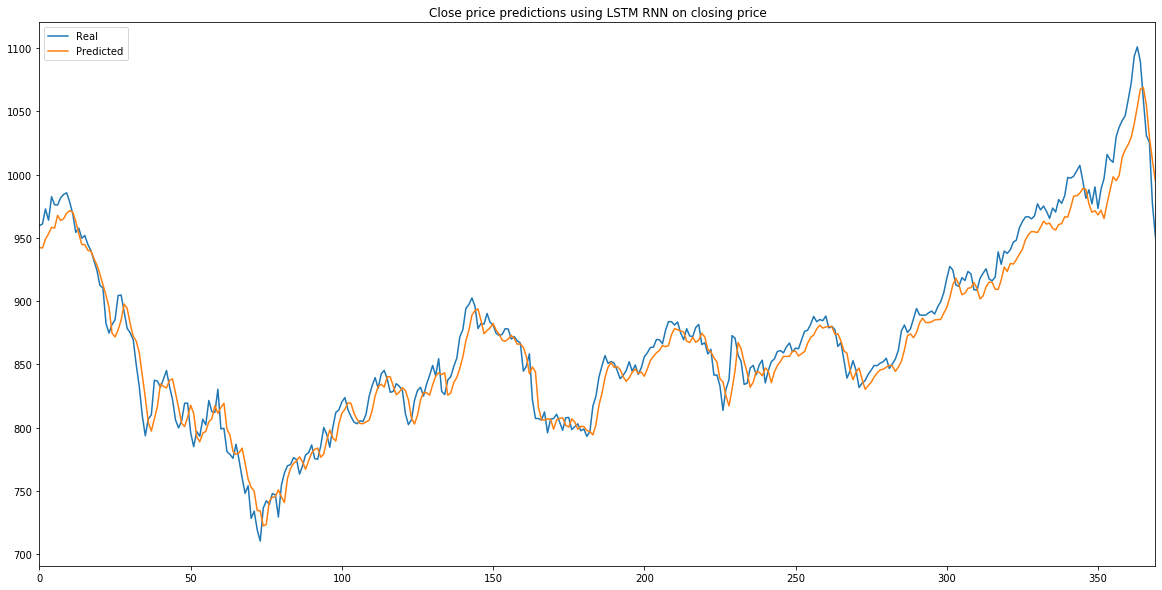

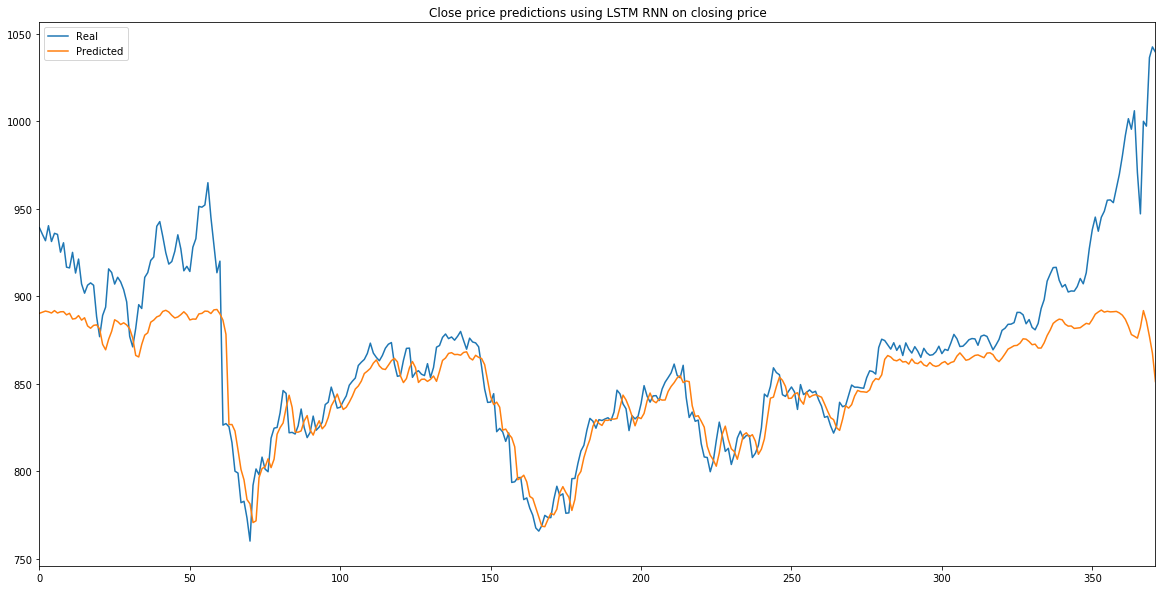

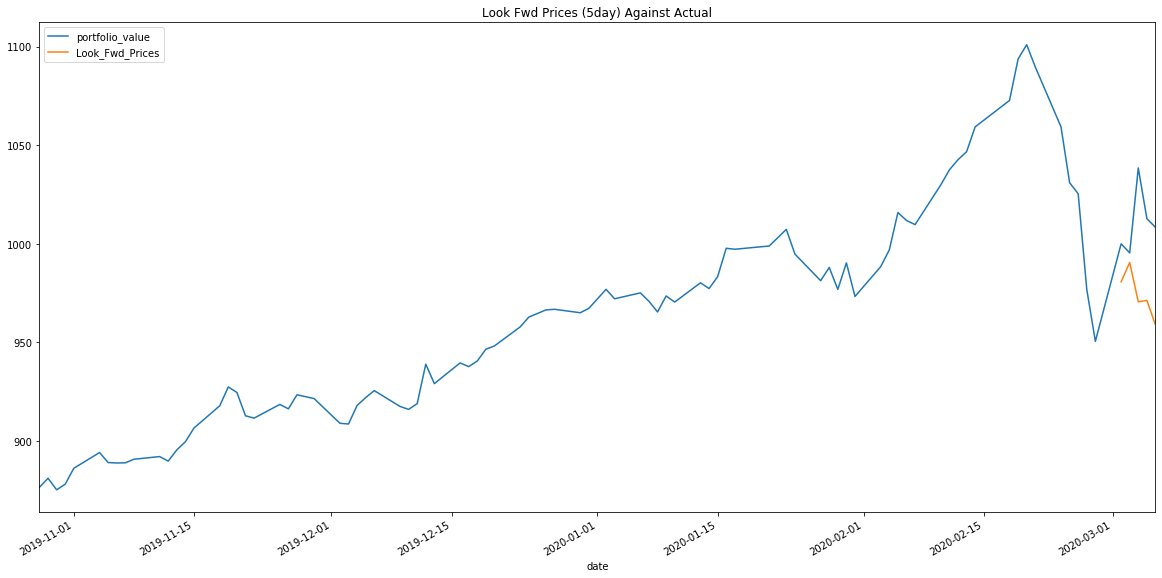

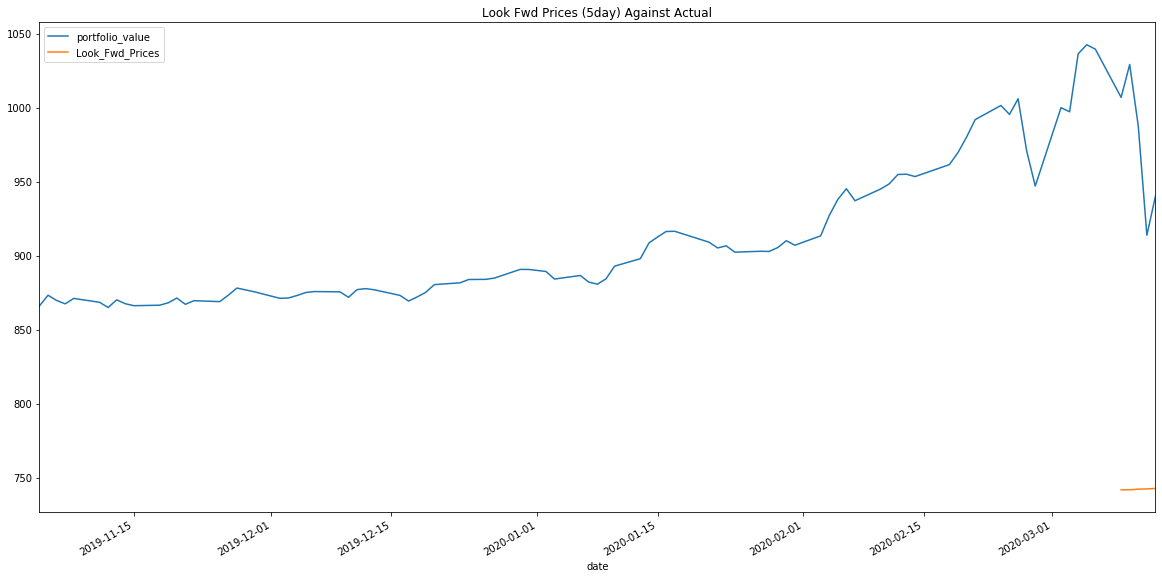

In [73]:

model_summary1 = model.summary()

model_summary2 = model2.summary()

STOCK_CLOSE=stock_closing.plot(title='Close price predictions using LSTM RNN on closing price',figsize=(20,10))

STOCK_CLOSE2=stock_closing2.plot(title='Close price predictions using LSTM RNN on closing price',figsize=(20,10))

LOOK_FWD_2020=look_fwd_2020.plot(figsize=(20,10),title='Look Fwd Prices (5day) Against Actual')

LOOK_FWD_2020_2=look_fwd_2020_2.plot(figsize=(20,10),title='Look Fwd Prices (5day) Against Actual')

In [74]:
import panel as pn
pn.extension('plotly')
from panel.interact import interact
import hvplot.pandas

In [75]:
LSTM_row = pn.Row(
    "## LSTM Summary",
    model_summary1,
    model_summary2
)

In [76]:
IN_SAMP_row = pn.Row(
    STOCK_CLOSE,
    STOCK_CLOSE2
)

In [77]:
OUT_SAMP_row = pn.Row(
    LOOK_FWD_2020,
    LOOK_FWD_2020_2
)

In [78]:
WK1_column = pn.Column(
    model_summary1,
    STOCK_CLOSE,
    LOOK_FWD_2020
)

In [79]:
WK2_column = pn.Column(
    model_summary2,
    STOCK_CLOSE2,
    LOOK_FWD_2020_2
)

In [80]:
comparison_column = pn.Column(
    LSTM_row,
    IN_SAMP_row,
    OUT_SAMP_row
)

In [81]:
dashboard = pn.Tabs(
    ("Comparison",comparison_column),
    ("WEEK 1",WK1_column),
    ("WEEK 2",WK2_column)
)

In [82]:
dashboard.servable()

Tabs
    [0] Column
        [0] Row
            [0] Markdown(str)
            [1] Str(Empty)
            [2] Str(Empty)
        [1] Row
            [0] Str(AxesSubplot)
            [1] Str(AxesSubplot)
        [2] Row
            [0] Str(AxesSubplot)
            [1] Str(AxesSubplot)
    [1] Column
        [0] Str(Empty)
        [1] Str(AxesSubplot)
        [2] Str(AxesSubplot)
    [2] Column
        [0] Str(Empty)
        [1] Str(AxesSubplot)
        [2] Str(AxesSubplot)